Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is to make the neural network convolutional.

In [25]:
# These are all the modules we'll be using later. Make sure you can import them before proceeding further.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

In [26]:
pickle_file = '/Users/desiredewaele/Google Drive/Datasets/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    trainX = save['train_dataset']
    trainY = save['train_labels']
    validX = save['valid_dataset']
    validY = save['valid_labels']
    testX = save['test_dataset']
    testY = save['test_labels']
    del save  # hint to help gc free up memory

## Helper Functions
These are some helper functions

In [27]:
def printShapes():
    print('Training set', trainX.shape, trainY.shape)
    print('Validation set', validX.shape, validY.shape)
    print('Test set', testX.shape, testY.shape)

In [28]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [29]:
def viewer(history):
    accBatch, accValid, lossBatch, lossValid = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(accBatch), 1), accBatch,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(accBatch[-1]))
    ax1.plot(np.arange(0, len(accValid), 1), accValid,".-", color='#FFA933', label="Validation: {0:.2f}%".format(accValid[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lossBatch), 1), lossBatch,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lossBatch[-1]))
    ax2.plot(np.arange(0, len(lossValid), 1), lossValid,".-", color='#FFA933', label="Validation: {0:.2f}".format(lossValid[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

## Data Preproccessing

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [30]:
printShapes()

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (10000, 28, 28), (10000,))


In [31]:
SIZE = 28
LABELS = 10
CHANNELS = 1 # grayscale
BREAKS = 100

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, SIZE, SIZE, CHANNELS)).astype(np.float32)
    labels = (np.arange(LABELS) == labels[:,None]).astype(np.float32)
    return dataset, labels
trainX, trainY = reformat(trainX, trainY)
validX, validY = reformat(validX, validY)
testX, testY = reformat(testX, testY)

In [32]:
printShapes()

('Training set', (200000, 28, 28, 1), (200000, 10))
('Validation set', (10000, 28, 28, 1), (10000, 10))
('Test set', (10000, 28, 28, 1), (10000, 10))


---
Problem 0
---------

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

---

In [33]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
STEPS = 501

In [42]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

    # Model.
    def model(x):
        x = tf.nn.conv2d(x, w1, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b1)
        x = tf.nn.conv2d(x, w2, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b2)
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions and Accuracy.
    predictions = tf.nn.softmax(model(tfDataX))
    accuracy = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predictions, 1), tf.argmax(tfDataY, 1))))

In [43]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.1f%%' % accuracy)


Test accuracy: 87.4%


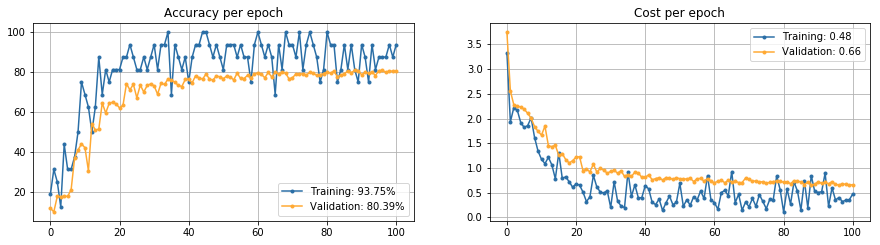

In [38]:
viewer(history)

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [17]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
STEPS = 1001

In [18]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))
    
    def model(x):
        # Convolutional layer 1
        x = tf.nn.conv2d(x, w1, [1, 1, 1, 1], padding='SAME') + b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Convolutional layer 2
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME') + b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Two fully conected layers
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.matmul(x, w3) + b3
        x = tf.nn.relu(x)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions and Accuracy.
    predictions = tf.nn.softmax(model(tfDataX))
    accuracy = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predictions, 1), tf.argmax(tfDataY, 1))))

In [19]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.1f%%' % accuracy)


Test accuracy: 90.6%


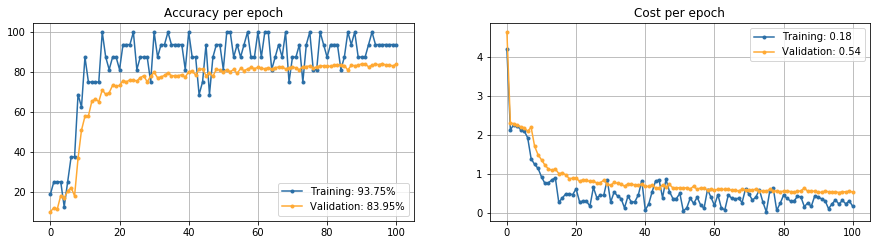

In [20]:
viewer(history)

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [21]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
STEPS = 20001

In [22]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    size3 = ((SIZE - PATCH + 1) // 2 - PATCH + 1) // 2
    w3 = tf.Variable(tf.truncated_normal([size3 * size3 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))
  
    # Model.
    def model(data):
        x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='VALID') + b1
        x = tf.nn.relu(x )
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='VALID') + b2
        x = tf.nn.relu(x)
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions and Accuracy.
    predictions = tf.nn.softmax(model(tfDataX))
    accuracy = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predictions, 1), tf.argmax(tfDataY, 1))))

In [23]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.1f%%' % accuracy)


Test accuracy: 94.5%


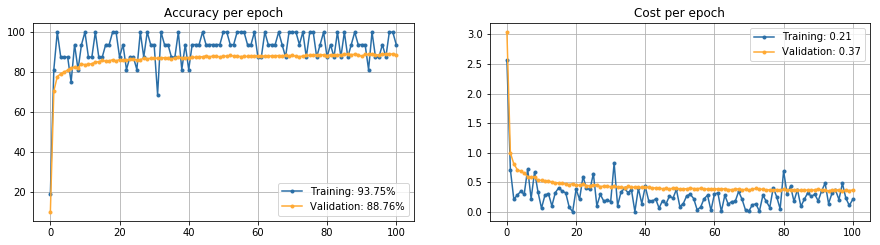

In [24]:
viewer(history)